# Lambda Iterations

In [1]:
import os
import sys
import matplotlib.pyplot as plt

magritteFolder = '/home/atulits/atulit/MasterThesis/Magritte/'

sys.path.append(magritteFolder)

import numpy             as np
import matplotlib.pyplot as plt
import magritte.setup    as setup
import magritte.core     as magritte

In [2]:
dimension = 1
npoints   = 100
nrays     = 200
nspecs    = 5
nlspecs   = 1
nquads    = 15

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
X_mol  = 1.0E-6   # [.]
temp   = 20.0     # [K]
turb   = 150.00   # [.]


def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

def nTT (r):
    return X_mol  * nH2(r)


rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)


modelFile = 'vanZadelhoff_1a_1D.hdf5'
lamdaFile = f'{magritteFolder}tests/data/test.txt'


model = magritte.Model ()
model.parameters.set_spherical_symmetry(True)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set([[r, 0, 0] for r in rs])
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_rays_spherical_symmetry (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()
model.read ()

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

/home/atulits/atulit/MasterThesis/Magritte/src/io/python/io_python_hdf5.py:83: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with hp.File (io_file) as file:
/home/atulits/atulit/MasterThesis/Magritte/src/io/python/io_python_hdf5.py:132: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with hp.File (io_file) as file:


0

In [3]:
def max_relative_difference(a, b):
    return np.max(2.0 * np.abs((a - b) / (a + b)))

In [4]:
def Anderson_acc_gen(x , num_it, l):
    unit = np.ones(num_it-1)
    #Column vectors for U matrix but here we have row matrix
    U_transpose = []
    for i in range(0,num_it-1):
            U_transpose.append((x[i] - x[i+1]))
    U_transpose = np.array(U_transpose)  
    
    #multiply two matrix
    M = np.matmul(U_transpose, U_transpose.T)
    
    # l is regularisation coefficient  
    # inverse of U and U_T
    M = np.linalg.inv(M + l*np.identity(len(M)))
    # Normalizaton factor
    Norm = np.linalg.multi_dot([unit,M,unit])
    #coeeficients c's
    c = np.matmul(M,unit)
    c = c/Norm
    print(sum(c))
    
    S_acc = 0
    for p in range(0,num_it-1):
        S_acc = S_acc + (c[p]*x[p+1])  
    return (S_acc,c)
    

In [5]:
Nmax = 100

nlev = model.lines.lineProducingSpecies[0].linedata.nlev
abn = np.array(model.chemistry.species.abundance, dtype=np.float64)[:,1]

it_diff = []
pops = []


#LTE Level population
pop  = np.copy(model.lines.lineProducingSpecies[0].population)
pops.append((pop.reshape((npoints,nlev)).T/abn).T.ravel())

#order of Anderson acc and regularization coefficient
m = 1
l = 0
Coefficients = []

for it in range(Nmax):
    # Compute radiation field and resulting populations
    if  it>=2: 
        A = []
        num_iterates = (m+2)
        for p in range(0,num_iterates):
            A.append(np.array(pops[p] , dtype = np.float64))
        print(len(A))
        S_acc , c = Anderson_acc_gen(A, num_iterates , l)
        
        Coefficients.append(c)
        
        #pot=(S_acc.reshape((npoints,nlev)).T*abn).T.ravel()
        #np.save("levelpop"+str(it),pot)
        #plt.plot(np.arange(len(pot)) , pot)
        #plt.yscale("log")
        #plt.savefig("levelpop"+str(it)+".png")
        #plt.show()
        
        model.lines.lineProducingSpecies[0].population = (S_acc.reshape((npoints,nlev)).T*abn).T.ravel()
        model.lines.set_emissivity_and_opacity()
        model.compute_radiation_field()
        model.compute_Jeff()
        model.compute_level_populations_from_stateq()
        
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)

        m = m+1
    else:
        model.compute_radiation_field()
        model.compute_Jeff()
        model.compute_level_populations_from_stateq()
        # Compute the maximum relative change
        pop = np.copy(model.lines.lineProducingSpecies[0].population)
    
    pops.append((pop.reshape((npoints,nlev)).T/abn).T.ravel())

    max_diff = max_relative_difference(pops[-1], pops[-2])
    it_diff.append(max_diff)
    # Check for convergence
    if (max_diff < 1.0e-6):
        break
    print('After', it, 'iteration(s), max_diff =', max_diff)

After 0 iteration(s), max_diff = 0.69066395650362435256
After 1 iteration(s), max_diff = 1.3868983562409521051
3
1.0
After 2 iteration(s), max_diff = 1.2173526160324876118
4
1.0000000000000002
After 3 iteration(s), max_diff = 1.447657544469801724
5
1.0
After 4 iteration(s), max_diff = 0.058575645570806204962
6
1.0
After 5 iteration(s), max_diff = 1.3733913523538792068
7
1.0
After 6 iteration(s), max_diff = 0.015614301794015085417
8
1.0
After 7 iteration(s), max_diff = 1.0491700251112773871
9
1.0
After 8 iteration(s), max_diff = 0.20583332229416725392
10
0.9999999999999998
After 9 iteration(s), max_diff = 0.12533957386016824328
11
1.0
After 10 iteration(s), max_diff = 0.16109049139826125572
12
0.9999999999999998
After 11 iteration(s), max_diff = 0.27198489523725379383
13
1.0000000000000002
After 12 iteration(s), max_diff = 0.21860051917150043144
14
0.9999999999999998
After 13 iteration(s), max_diff = 0.12428307511894415781
15
0.9999999999999999
After 14 iteration(s), max_diff = 1.118980

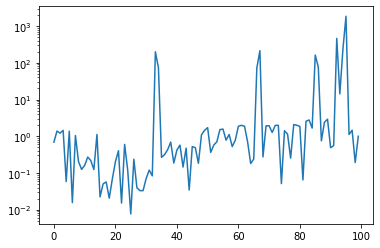

In [6]:
np.save("Lambda_online_it",pops)
plt.plot(np.arange(len(it_diff)) , it_diff)
plt.yscale("log")
plt.savefig("plot.png")
plt.show()


[0.37767168 0.62232832]
[ 0.22986698 -0.401859    1.17199202]
[ 0.23407607 -0.41118591  1.21553803 -0.03842819]
[-0.0017097   0.00484832 -0.0288911   0.05450051  0.97125198]
[-0.00123207  0.00194237 -0.01178387  0.02337434  0.96221537  0.02548386]
[-1.25196535e-04  8.69267157e-04 -6.06543023e-03  1.44045939e-02
  1.44290363e-01 -1.57740805e-02  8.62400483e-01]
[-1.35668021e-04  3.05960303e-04 -2.17796835e-03  5.14740151e-03
  2.66395831e-01  1.04395697e-02  7.38808116e-01 -1.87832416e-02]
[-2.65179411e-05  2.49550021e-05 -3.77583655e-04  9.45845689e-04
  1.07986405e-01  1.06561739e-02  1.18081656e+00 -6.66298424e-02
 -2.33395996e-01]
[ 1.71740310e-06  7.22783124e-06 -1.86593450e-04  7.67129746e-04
  8.61483622e-03  3.19559819e-03  1.29664615e+00 -6.88424329e-02
 -2.77178060e-01  3.69744244e-02]
[-1.27527238e-07 -9.92735029e-06 -2.79453358e-05  2.26698239e-04
  1.31858599e-03  3.36861523e-03  9.72081173e-01 -5.60829598e-02
 -1.03310972e-01  8.00142065e-03  1.74435439e-01]
[-6.27810887e-

<StemContainer object of 3 artists>

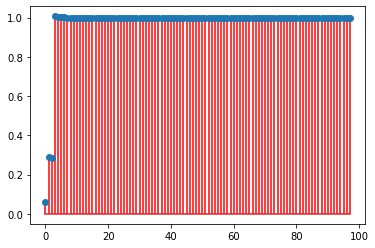

In [7]:
l_norm = []
for c in Coefficients:
    size = c[0] - np.sum(c[1:])
    l_norm.append(size**2) 
    print(c)
plt.stem(np.arange(len(l_norm)) , l_norm , 'ro')

In [8]:
pops_lambda  = np.load("Lambda_it.npy")
print(pops_lambda[-1])

[0.34465468 0.65534532 0.34580997 0.65419003 0.34710942 0.65289058
 0.34866014 0.65133986 0.35050876 0.64949124 0.35271011 0.64728989
 0.35532826 0.64467174 0.35843762 0.64156238 0.36212407 0.63787593
 0.36648595 0.63351405 0.3716348  0.6283652  0.37769562 0.62230438
 0.38480646 0.61519354 0.39311699 0.60688301 0.40278565 0.59721435
 0.4139751  0.5860249  0.42684542 0.57315458 0.44154502 0.55845498
 0.45819897 0.54180103 0.47689535 0.52310465 0.49767022 0.50232978
 0.52049282 0.47950718 0.54525289 0.45474711 0.5717525  0.4282475
 0.59970483 0.40029517 0.62874139 0.37125861 0.65842845 0.34157155
 0.68829142 0.31170858 0.71784451 0.28215549 0.746622   0.253378
 0.77420678 0.22579322 0.80025245 0.19974755 0.82449729 0.17550271
 0.8467687  0.1532313  0.86697981 0.13302019 0.88511981 0.11488019
 0.90124034 0.09875966 0.91544054 0.08455946 0.92785237 0.07214763
 0.93862754 0.06137246 0.94792666 0.05207334 0.95591089 0.04408911
 0.96273587 0.03726413 0.96854777 0.03145223 0.97348084 0.0265191